In [1]:
include("models/ppl/main.jl")
using PyCall
using CairoMakie
sepsis_gym = pyimport("custom_sepsis")
using Statistics

struct TSType
    # policies::Dict{Int, Vector{Policy}}
    mean_rewards::Dict{Int, Float64}
    name::String
    info::Dict
end

In [2]:
using JSON3
using Serialization

function load_ts_from_json(file_path::String)::TSType
    json_data = JSON3.read(file_path)
    mean_rewards = Dict{Int, Float64}(
        parse(Int, string(k)) => Float64(v) for (k, v) in json_data["mean_rewards"]
    )
    name = json_data["info"]["name"]
    # info = Dict(json_data["info"])
    info = Dict(
        string(k) => string(v) for (k, v) in json_data["info"]
    )
    return TSType(mean_rewards, name, info)
end

load_ts_from_json (generic function with 1 method)

In [74]:
ts = Dict(
    :Simple => [sepsis_gym.DirThompsonSampling.load_json("json/dirichlet/ts/Simple-$i.json") for i in 0:2],
    :Medium => [sepsis_gym.DirThompsonSampling.load_json("json/dirichlet/ts/Medium-$i.json") for i in 0:2],
    :None => [sepsis_gym.DirThompsonSampling.load_json("json/dirichlet/ts/None-$i.json") for i in 0:2],
    :DQN => [load_ts_from_json("json/dqn/ts/DQN-$i.json") for i in 0:2],
    :Softmax => [load_jld("data/mcmc/ts/SoftmaxPPL-$i.jld")  for i in 1:3],
    :SimplePPL => [load_jld("data/mcmc/ts/SimplePPL-$i.jld")  for i in 1:3]
)

Dict{Symbol, Vector} with 6 entries:
  :SimplePPL => PPTSRun[PPTSRun("SimplePPL-1", MCMCModel(:SimplePPL, DynamicCho…
  :Softmax   => PPTSRun[PPTSRun("SoftmaxPPL-1", MCMCModel(:Softmax, DynamicChoi…
  :None      => PyObject[PyObject <custom_sepsis.models.dirichlet.evaluate.thom…
  :Medium    => PyObject[PyObject <custom_sepsis.models.dirichlet.evaluate.thom…
  :DQN       => TSType[TSType(Dict(200=>-0.61762, 16=>-0.84724, 4700=>-0.41784,…
  :Simple    => PyObject[PyObject <custom_sepsis.models.dirichlet.evaluate.thom…

In [5]:
random_mean = -0.6662000000000002 #mean([sepsis_gym.evaluate_policy(sepsis_gym.random_policy(), 1000) for i in 1:100])

-0.6662000000000002

In [75]:
function moving_avg(data, window_size=100)
    half_window = div(window_size, 2)
    
    # Pad the data with the edge values to handle borders
    padded_data = vcat(data[1:half_window], data, data[end-half_window:end])
    
    # Compute the moving average using a sliding window
    smoothed = [mean(padded_data[i:i+window_size-1]) for i in 1:length(data)]
    
    return smoothed
end


moving_avg (generic function with 2 methods)

In [76]:

colors_dict = Dict(
    :Simple => colors[1],
    :Medium => colors[4],
    :None => colors[6],
    :Softmax => colors[3],
    :SimplePPL => colors[2],
    :DQN => colors[5],
)

Dict{Symbol, Tuple{FixedPointNumbers.N0f8, FixedPointNumbers.N0f8, FixedPointNumbers.N0f8}} with 6 entries:
  :DQN       => (0.82, 0.675, 0.0)
  :Softmax   => (0.0, 0.549, 0.0)
  :None      => (0.529, 0.0, 0.212)
  :Medium    => (0.0, 0.498, 0.694)
  :SimplePPL => (0.82, 0.29, 0.0)
  :Simple    => (0.78, 0.129, 0.867)

In [77]:
function plot_mean_rewards(ts, window_size=5, x_lim=6000)
    fig = Figure(resolution=(700, 500))  
    ax = Axis(fig[1, 1], xlabel = "Number of Episodes", ylabel = "Mean Reward Across 100'000 Episodes", title = "Mean Rewards for Thompson Sampling with Batch Size 100")

    window_size = 5 # Adjust the window size as needed

    # Data storage for accessing smoothed values later
    data = Dict()

    ks = []
    for (i, type) in enumerate([:SimplePPL, :Softmax, :Simple, :Medium, :None, :DQN])
        if isempty(ts[type])
            continue
        end

        all_keys = [sort(collect(keys(model.mean_rewards))) for model in ts[type]]
        min_keys = minimum(length.(all_keys))
        ks = all_keys[1][1:min_keys]
        filled_rewards = []
        all_rewards = []
        for model in ts[type]
            rewards = [model.mean_rewards[1]]
            for i in 2:min_keys
                key = all_keys[1][i]
                mult_factor = key - all_keys[1][i-1]
                push!(rewards, fill(model.mean_rewards[key], mult_factor)...)
            end
            push!(all_rewards, [model.mean_rewards[k] for k in ks])
            push!(filled_rewards, rewards)
            lines!(ax, Float64.(rewards), color=(colors_dict[type], 0.2))
        end
        mean_rewards = mean(all_rewards)
        smoothed_mean_rewards = moving_avg(mean_rewards, window_size)
        lines!(ax, ks, Float64.(smoothed_mean_rewards), color=colors_dict[type], linewidth=1.5, label=label_dict[type])

        std_rewards = std(all_rewards)
        smoothed_std_rewards = Float64.(moving_avg(std_rewards, window_size))
        low = smoothed_mean_rewards .- smoothed_std_rewards
        high = smoothed_mean_rewards .+ smoothed_std_rewards
        band!(ax, Float64.(ks), low, high, color=(colors_dict[type], 0.2))

        # Save smoothed data for future use
        data[type] = mean_rewards
    end

    lines!(ax, ks, fill(random_mean, length(ks)), color=:black, linestyle=:dash, label="Random Policy")
    axislegend(ax)

    xlims!(ax, 0, x_lim)
    
    save("mean_rewards.png", fig)
    display(fig)

    return data
end


plot_mean_rewards (generic function with 3 methods)

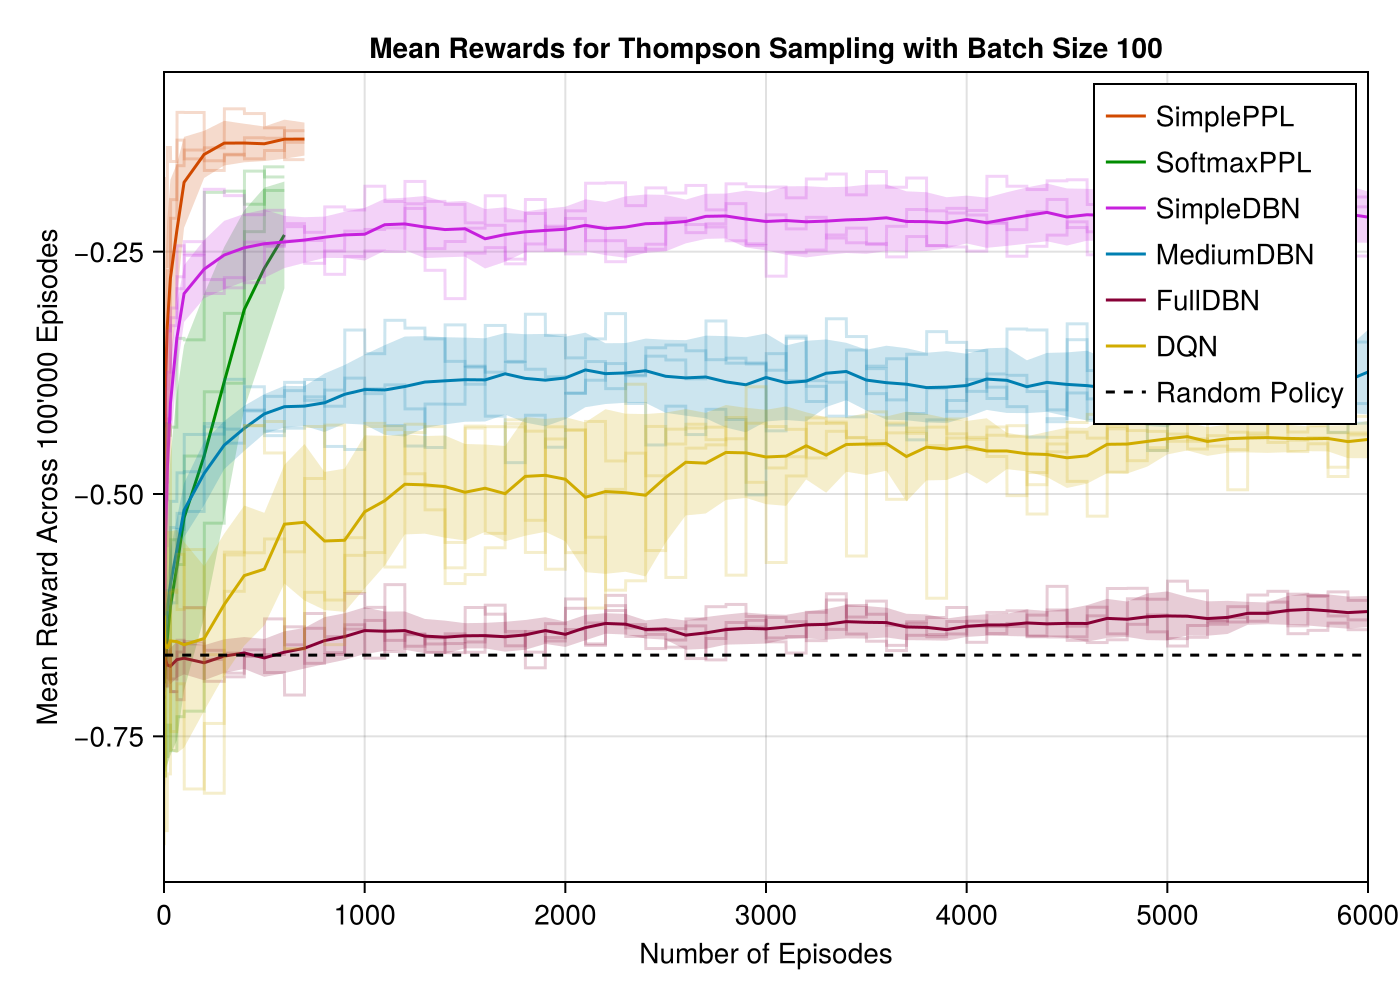

┌ Warning: Found `resolution` in the theme when creating a `Scene`. The `resolution` keyword for `Scene`s and `Figure`s has been deprecated. Use `Figure(; size = ...` or `Scene(; size = ...)` instead, which better reflects that this is a unitless size and not a pixel resolution. The key could also come from `set_theme!` calls or related theming functions.
└ @ Makie /Users/luisastue/.julia/packages/Makie/Y3ABD/src/scenes.jl:238


Dict{Any, Any} with 6 entries:
  :DQN       => [-0.59997, -0.630893, -0.664483, -0.656597, -0.720483, -0.60653…
  :Softmax   => [-0.66947, -0.68896, -0.71846, -0.71067, -0.62486, -0.614397, -…
  :None      => [-0.658183, -0.67427, -0.668743, -0.675217, -0.68237, -0.655837…
  :Medium    => [-0.671667, -0.64189, -0.64451, -0.65426, -0.637087, -0.61023, …
  :SimplePPL => [-0.624323, -0.453003, -0.38704, -0.38049, -0.403743, -0.27822,…
  :Simple    => [-0.671597, -0.62753, -0.618317, -0.584957, -0.48352, -0.378143…

In [78]:
mean_rewards = plot_mean_rewards(ts)


In [83]:
using JSON3

function save_ts_to_json(ts_instance::TSType, file_path::String)
    json_data = Dict(
        "mean_rewards" => ts_instance.mean_rewards,
        "name" => ts_instance.name,
        "info" => ts_instance.info
    )
    JSON3.write(file_path, json_data)
end


save_ts_to_json (generic function with 1 method)

In [ ]:
DQNs = []
for i in 1:3
    mean_rewards = Dict()
    for len in 1:500
        training = nothing
        try
            training = sepsis_gym.Training.load("data/trainings/DQN-$(len)_object.pkl")
        catch
            training = sepsis_gym.train_dqn(sepsis_gym.true_env, len, len)
        end
        mean_rewards[len] = training.evaluate_policy(100000)
    end
    ts_instance = TSType(mean_rewards, "DQN-every-$i", Dict("name" => "DQN-every-$i"))
    save_ts_to_json(ts_instance, "json/dqn/ts/DQN-every-$i.json")
    push!(DQNs, ts_instance)
end


In [ ]:
ts_every = Dict(
    :Simple => [],
    :Medium => [],
    :None => [],
    :DQN => [load_ts_from_json("json/dqn/ts/DQN-every-$i.json") for i in 1:3],
    :Softmax => [load_jld("data/mcmc/ts/SoftmaxPPL-every-$i.jld")  for i in 1:3],
    :SimplePPL => [load_jld("data/mcmc/ts/SimplePPL-every-$i.jld")  for i in 1:3]
)

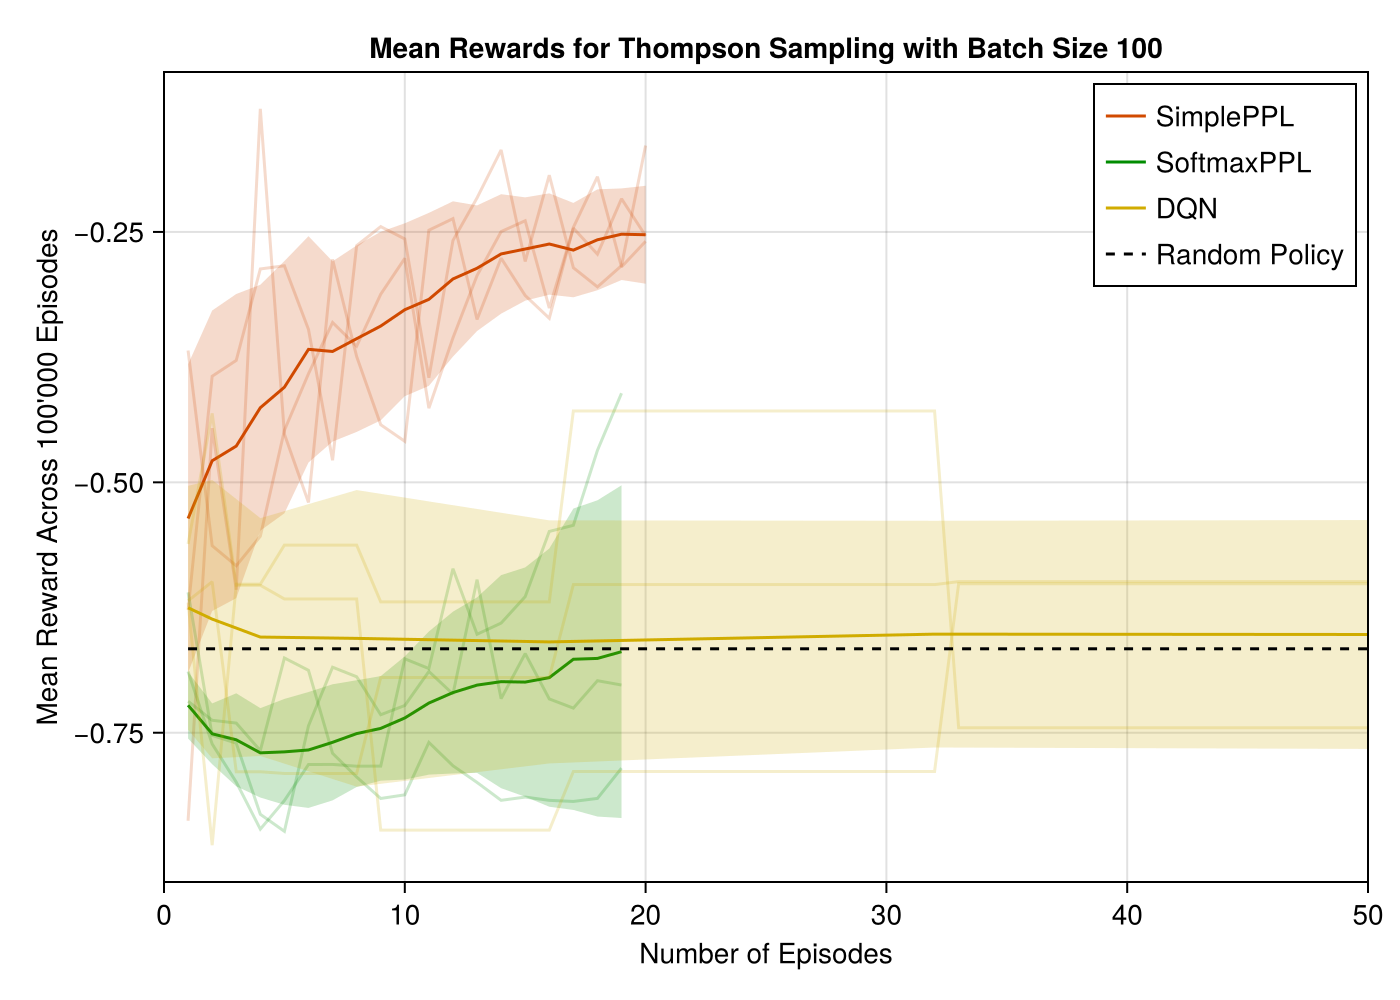

┌ Warning: Found `resolution` in the theme when creating a `Scene`. The `resolution` keyword for `Scene`s and `Figure`s has been deprecated. Use `Figure(; size = ...` or `Scene(; size = ...)` instead, which better reflects that this is a unitless size and not a pixel resolution. The key could also come from `set_theme!` calls or related theming functions.
└ @ Makie /Users/luisastue/.julia/packages/Makie/Y3ABD/src/scenes.jl:238


Dict{Any, Any} with 3 entries:
  :Softmax   => [-0.67245, -0.750493, -0.7667, -0.81518, -0.780507, -0.73752, -…
  :SimplePPL => [-0.611203, -0.467777, -0.522927, -0.32263, -0.39457, -0.41968,…
  :DQN       => [-0.59997, -0.630893, -0.664483, -0.656597, -0.720483, -0.60653…

In [82]:
mean_rewards = plot_mean_rewards(ts_every, 1, 50)


In [51]:
# colors = Makie.wong_colors()

In [14]:
type_labels = Dict(
    :Softmax => "\\mathsf{SoftmaxPPL}",
    :None => "\\mathsf{FullDBN}",
    :Medium => "\\mathsf{MediumDBN}",
    :DQN => "\\mathsf{DQN}",
    :Simple => "\\mathsf{SimpleDBN}"
)

Dict{Symbol, String} with 5 entries:
  :Softmax => "\\mathsf{SoftmaxPPL}"
  :None    => "\\mathsf{FullDBN}"
  :Medium  => "\\mathsf{MediumDBN}"
  :DQN     => "\\mathsf{DQN}"
  :Simple  => "\\mathsf{SimpleDBN}"

In [15]:

# Generate LaTeX table
function generate_latex_table(cumsums, checkpoints, type_labels)
    table = "\\begin{tabular}{|l|" * "r|"^length(checkpoints) * "}\n\\hline\n"
    table *= " & " * join(["\$" * string(ch) * "\$" for ch in checkpoints], " & ") * " \\\\ \\hline\n"

    for (key, values) in cumsums
        label = type_labels[key]
        # Generate row data, only include values where checkpoints are valid
        row_data = []
        for checkpoint in checkpoints
            if checkpoint <= length(values)
                push!(row_data, string("\$", round(values[checkpoint ÷ 10], digits=2), "\$"))
            else
                push!(row_data, "-")
            end
        end
        table *= "\$" * label * "\$ & " * join(row_data, " & ") * " \\\\ \\hline\n"
    end

    table *= "\\end{tabular}\n"
    return table
end

generate_latex_table (generic function with 1 method)

In [16]:
cumsums = Dict(type => accumulate(.+, mean_rewards[type]) for type in keys(mean_rewards))

Dict{Symbol, Vector{Float64}} with 6 entries:
  :Simple    => [-0.671597, -1.29913, -1.91744, -2.5024, -2.98592, -3.36406, -3…
  :Softmax   => [-0.66947, -1.35843, -2.07689, -2.78756, -3.41242, -4.02682, -4…
  :None      => [-0.658183, -1.33245, -2.0012, -2.67641, -3.35878, -4.01462, -4…
  :Medium    => [-0.671667, -1.31356, -1.95807, -2.61233, -3.24941, -3.85964, -…
  :DQN       => [-0.59997, -1.23086, -1.89535, -2.55194, -3.27243, -3.87896, -4…
  :SimplePPL => [-0.624323, -1.07733, -1.46437, -1.84486, -2.2486, -2.52682, -2…

In [17]:
print(generate_latex_table(cumsums, [10,100, 1000, 5000], type_labels))

KeyError: KeyError: key :SimplePPL not found

In [18]:
for type in keys(cumsums)
    for checkpoint in [10,100, 1000, 5000]
        if checkpoint > length(cumsums[type])
            continue
        end
    
        println("Type: $type")
        println("Checkpoint: $checkpoint")
        println("Cumsum: ", cumsums[type][checkpoint])
    end
    println()
end

Type: Simple
Checkpoint: 10
Cumsum: -4.45206

Type: Softmax
Checkpoint: 10
Cumsum: -6.034786666666666

Type: None
Checkpoint: 10
Cumsum: -6.70579

Type: Medium
Checkpoint: 10
Cumsum: -5.832436666666666

Type: DQN
Checkpoint: 10
Cumsum: -6.549956666666667

Type: SimplePPL
Checkpoint: 10
Cumsum: -3.1408666666666667

